In [1]:
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import networkx as nx
import ast

In [2]:

def read_graph_from_gml(file, draw=False):
    G = nx.read_gml(file)
    file_name = file[0:-4]
    if file_name == 'Surfnet':
        # The Dutch Topology Zoo dataset
        end_node_list = ["Middelburg", "Groningen", "Maastricht", "Enschede", "Delft", "Amsterdam", "Utrecht", "Den_Helder"]
    elif file_name == "SurfnetFiberdata":
        end_node_list = ["Asd001b", "Mt001a", "GN001A", "DT001A"]
    elif file_name == "SurfnetCore":
        end_node_list = ["Amsterdam 1", "Delft 1", "Groningen 1", "Maastricht", "Enschede 2"]
    elif file_name == 'Colt':
        # The European Topology Zoo dataset
        # Use QIA members: IQOQI, UOI (Innsbruck), CNRS (Paris), ICFO (Barcelona), IT (Lisbon),
        #              MPQ (Garching [DE] -> Munich), NBI (Copenhagen), QuTech (Delft -> The Hague), UOB (Basel),
        #              UOG (Geneva)
        # NOTE: Graching replaced by Munich, Delft by The Hague
        end_node_list = ['Innsbruck', 'Paris', 'Barcelona', 'Lisbon', 'Copenhagen', 'TheHague', 'Basel', 'Geneva',
                         'Stuttgart']
    else:
        raise NotImplementedError("Dataset {} not implemented (no city list defined)".format(file_name))
    pos = {}
    for node, nodedata in G.nodes.items():
        if "position" in nodedata:
            pos[node] = ast.literal_eval(nodedata["position"])
        elif "Longitude" in nodedata and "Latitude" in nodedata:
            pos[node] = [nodedata['Longitude'], nodedata['Latitude']]
        else:
            raise ValueError("Cannot determine node position.")
#         if node in end_node_list:
#             nodedata['type'] = 'end_node'
#         else:
        nodedata['type'] = 'repeater_node'
    nx.set_node_attributes(G, pos, name='pos')
    if draw:
        draw_graph(G)
    return G

# def compute_dist_lat_lon(graph):
def compute_dist_lat_lon(edge,graph):
    """Compute the distance in km between two points based on their latitude and longitude.
    Assumes both are given in radians."""
    R = 6371  # Radius of the earth in km
#     dist = []
#     for edge in graph.edges():
    node1, node2 = edge
#         print(node1,node2)
    lon1 = np.radians(graph.nodes[node1]['Longitude'])
    lon2 = np.radians(graph.nodes[node2]['Longitude'])
    lat1 = np.radians(graph.nodes[node1]['Latitude'])
    lat2 = np.radians(graph.nodes[node2]['Latitude'])
    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1
    a = np.sin(delta_lat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * (np.sin(delta_lon / 2) ** 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
#         dist.append(np.round(R * c, 5))
    return np.round(R * c, 5)

def draw_graph(G):
    pos = nx.get_node_attributes(G, 'pos')
    repeater_nodes = []
    end_nodes = []
    for node in G.nodes():
        if G.nodes[node]['type'] == 'repeater_node':
            repeater_nodes.append(node)
        else:
            end_nodes.append(node)
    fig, ax = plt.subplots(figsize=(7, 7))
    end_nodes = nx.draw_networkx_nodes(G=G, pos=pos, nodelist=end_nodes, node_shape='s', node_size=1500,
                                       node_color=[[1.0, 120 / 255, 0.]], label="End Node", linewidths=3)
#     end_nodes.set_edgecolor('K')
    rep_nodes = nx.draw_networkx_nodes(G=G, pos=pos, nodelist=repeater_nodes, node_size=70,
                                       node_color=[[1, 1, 1]], label="Repeater Node")
    rep_nodes.set_edgecolor('black')
    end_node_labels = {}
    repeater_node_labels = {}
    for node, nodedata in G.nodes.items():
        # labels[node] = node
        if G.nodes[node]['type'] == 'end_node':  # or node in self.repeater_nodes_chosen:
            end_node_labels[node] = node
        else:
            repeater_node_labels[node] = node
#     nx.draw_networkx_labels(G=G, pos=pos, labels=end_node_labels, font_size=3, font_weight="bold", font_color="w",
#                             font_family='serif')
    pos_txt = pos.copy()
#     print(pos_txt)
    nx.draw_networkx_edges(G=G, pos=pos, width=1)
    for node in pos_txt:
        pos_txt[node][1]= pos_txt[node][1]+0.04
    nx.draw_networkx_labels(G=G, pos=pos_txt, labels=repeater_node_labels, font_size=5, font_weight="bold")
    plt.axis('off')
    margin = 0.33
    fig.subplots_adjust(margin, margin, 1. - margin, 1. - margin)
    ax.axis('equal')
    fig.tight_layout()
    plt.savefig("surfnet.pdf")
    plt.show()

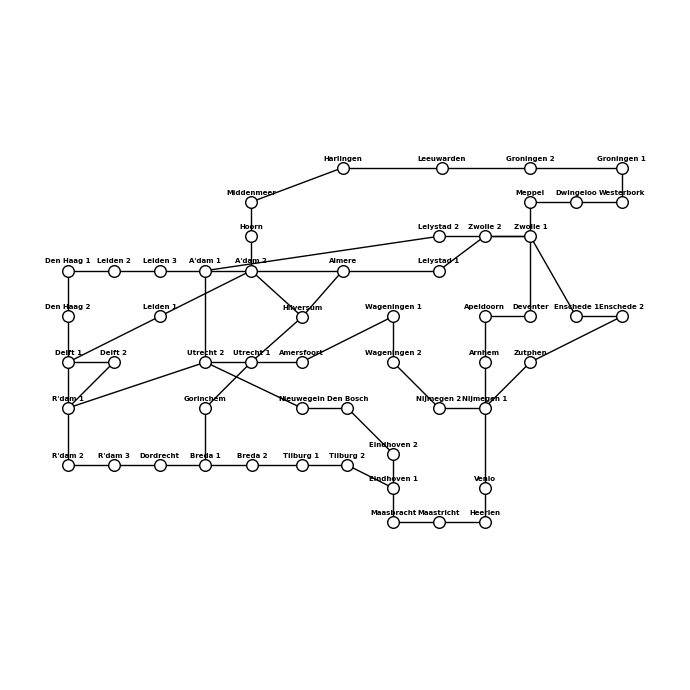

In [3]:
G = read_graph_from_gml("SurfnetCore.gml", draw=True)
# G = read_graph_from_gml("SurfnetFiberdata.gml", draw=True)
# G = read_graph_from_gml(f_dir+"ESnet2.gml", draw=True)
# pos = nx.get_node_attributes(G, 'pos')
# nx.draw_networkx(G=G,  width=1, node_size = 20, with_labels=True, font_size=6, pos=pos)
